<a href="https://colab.research.google.com/github/licTomasPerez/Spin-Chains-/blob/main/HS_projected_evolution_debugged.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qutip
!pip install scipy
!pip install matplotlib.inline
!pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.7 MB 7.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


1. Construir los operador x, p, conmutadores
2. 

In [35]:
import qutip
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import pickle
import math, cmath
from IPython.display import display, Math, Latex

In [36]:
def prod_basis(b1, b2):
  return [qutip.tensor(b,s) for b in b1 for s in b2]

def scalar_prod(op1, op2, rho0 = None):
  if op1.dims[0][0]!=op2.dims[0][0]:
    return "Incompatible Qobj dimensions"
  if rho0 is None:
    rho0 = qutip.qeye(op1.dims[0])/op1.dims[0][0]
  result = .5*(rho0*(op1*op2.dag()+op2.dag()*op1)).tr()
  result = result.real
  return result

def base_orth(ops, rho0):
  print("base")
  if isinstance(ops[0], list):
    ops = [op for op1l in ops for op in op1l]
  print(type(ops),type(ops[0]))
  dim = ops[0].dims[0][0]
  print("dim=",dim)
  basis = []
  for op in ops: 
    alpha = [scalar_prod(op2, op, rho0) for op2 in basis]
    op_mod = op - sum([c*op2 for c, op2, in zip(alpha, basis)])
    op_mod = op_mod/(np.sqrt(scalar_prod(op_mod,op_mod,rho0)))
    basis.append(op_mod)
  return basis

def logM(rho):
  eigvals, eigvecs = rho.eigenstates()
  return sum([np.log(vl)*vc*vc.dag() for vl, vc in zip(eigvals, eigvecs) if vl > 0])

def sqrtM(rho):
  eigvals, eigvecs = rho.eigenstates()
  return sum([(abs(vl)**.5)*vc*vc.dag() for vl, vc in zip(eigvals, eigvecs)])

def proj_op(K, basis, rho0):
  return sum([scalar_prod(b, K,rho0) * b for b in basis])

def rel_entropy(rho, sigma):
    val = (rho*(logM(rho)-logM(sigma))).tr()
    if abs(val.imag)>1.e-6:
        print("rho or sigma not positive")
        print(rho.eigenstates())
        print(sigma.eigenstates())
    return val.real

In [37]:
def bures(rho, sigma):
    val = abs((sqrtM(rho)*sqrtM(sigma)).tr())
    val = max(min(val,1.),-1.)
    return np.arccos(val)/np.pi
        
def maxent_rho(rho, basis):   
    def test(x, rho, basis):
        k = sum([-u*b for u,b in zip(x, basis)])        
        sigma = (.5*(k+k.dag())).expm()
        sigma = sigma/sigma.tr()
        return rel_entropy(rho, sigma)    
    res = opt.minimize(test,np.zeros(len(basis)),args=(rho,basis))
    k = sum([-u*b for u,b in zip(res.x, basis)])        
    sigma = (.5*(k+k.dag())).expm()
    sigma = sigma/sigma.tr()
    return sigma
 
def error_maxent_state(rho, basis, distance=bures):
    try:
        sigma = maxent_rho(rho, basis)
        return distance(rho,sigma)
    except:
        print("fail")
        return None
       
def error_proj_state(rho, rho0, basis, distance=bures):
    try:
        basis = base_orth(basis, rho0)
    except:
      print ("orth error")
      raise
    try:
        sigma = proj_op(logM(rho), basis, rho0).expm()
    except:
      print("gram error")
    try:
        return distance(rho, sigma)
    except:
        print("fail error proj state")
        return None

In [40]:
N = 5            # número de spines

h  = 1.0 * 2 * np.pi * np.ones(N) 
Jx = 0.15 * 2 * np.pi * np.ones(N)
Jy = 0.25 * 2 * np.pi * np.ones(N)
Jz = 0.1 * 2 * np.pi * np.ones(N)

id2 = qutip.qeye(2)
sx = .5*qutip.sigmax()
sy = .5*qutip.sigmay()
sz = .5*qutip.sigmaz()

sx_list = []
sy_list = []
sz_list = []

for n in range(N):
    operator_list = []
    for m in range(N):
        operator_list.append(id2)
    operator_list[n] = sx
    sx_list.append(qutip.tensor(operator_list))
        
    operator_list[n] = sy
    sy_list.append(qutip.tensor(operator_list))
        
    operator_list[n] = sz
    sz_list.append(qutip.tensor(operator_list))

def Heisenberg_hamiltonian (N, Jx, Jy, Jz, h):
  H = 0
  for n in range(N):
    H += -0.5*h[n]*sz_list[n]
        
  for n in range(N-1):
    H += -0.5 * Jx[n] * sx_list[n] * sx_list[n+1]
    H += -0.5 * Jy[n] * sy_list[n] * sy_list[n+1]
    H += -0.5 * Jz[n] * sz_list[n] * sz_list[n+1]
  return H

x_op = sum((.5 - sz_list[a])*a for a in range(N))
p_op = 1j * (x_op*Heisenberg_hamiltonian (N, Jx, Jy, Jz, h) - Heisenberg_hamiltonian (N, Jx, Jy, Jz, h)*x_op)
comm_xp = .5*(x_op*p_op + p_op*x_op)
corr_op = -1j*(x_op*p_op - p_op*x_op)
p_dot = 1j*(Heisenberg_hamiltonian (N, Jx, Jy, Jz, h) * p_op - p_op * Heisenberg_hamiltonian (N, Jx, Jy, Jz, h))

entropy_VN = []
def callback_entropy_VN (t,rhot):
    entropy_VN.append(qutip.entropy_vn(rhot))


In [61]:
psi1_list = []
psi1_list.append(qutip.basis(2,1))
for n in range(4):
    psi1_list.append(qutip.basis(2,0))

psi2_list = []
psi2_list.append(qutip.basis(2,0))
psi2_list.append(qutip.basis(2,1))
for n in range(3):
    psi2_list.append(qutip.basis(2,0))

psi01 = qutip.tensor(psi1_list) ## siendo este un estado puro, su entropía de VN es cero
psi02 = qutip.tensor(psi2_list) 
psi0 = psi01+psi02 

In [60]:
print(r"$$S(\psi_01)=$$", qutip.entropy_vn(psi01))
print(r"$$S(\psi_02)=$$", qutip.entropy_vn(psi02))
print(r"$$S(\psi_01+\psi_02)=$$", qutip.entropy_vn(psi01))

$$S(\psi_01)=$$ -0.0
$$S(\psi_02)=$$ -0.0
$$S(\psi_01+\psi_02)=$$ -0.0


In [43]:
class Result(object):
    def __init__(self, ts=None, states=None):
        self.ts = ts
        self.states = states
        self.projrho0_app = None   
        self.projrho_inst_app = None 

In [57]:
def spin_dephasing(gamma):
  c_op_list = []
  collapse_weights = gamma * np.ones(N)
  for n in range(N):
        if collapse_weights[n] > 0.0:
            c_op_list.append(np.sqrt(collapse_weights[n]) * sz_list[n])
  return c_op_list

Considero un estado inicial descorrelacionado de la forma de 

$$
\rho_0 = x |\Phi\rangle \langle\Phi| + (1-x)\frac{{I_d}}{d}
$$

In [62]:
def projected_evolution(x=.5, gamma = 1*np.e*-2, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=10., tmax = 500., distance=bures):
    basis = [sx_list, sy_list, sz_list]
    H_H = Heisenberg_hamiltonian(N,Jx,Jy,Jz,h)
    rho0 = psi0 * psi0.dag()
    rho0 = x * rho0/rho0.tr() + (1-x) * qutip.tensor([.5*qutip.qeye(2) for k in range(N)])
    # Hamiltoniano    

    obs = [x_op, p_op, x_op**2,p_op**2, corr_op, p_dot]

    sampling = int(10*max(1,omega_1, omega_2)*deltat)
    
    c_op_list = spin_dephasing(gamma)

    states = [rho0]
    rho = rho0    
    ts= [0]
    for i in range(int(tmax/deltat)):
        result = qutip.mesolve(H_H, states[-1], np.linspace(0,deltat, sampling), obs, args={'gamma': gamma,'omega_1': omega_1, 'omega_2': omega_2})
        states.append(result.states[-1])
        ts.append(deltat*i)
    result = Result(ts, states)
    result.times = ts
    result.states = states
    result.projrho0_app = np.array([error_proj_state(rho, rho0, basis,distance) for rho in states])
#    result.projrho_inst_app = np.array([error_proj_state(rho, qutip.tensor(rho.ptrace([0]),rho.ptrace([1])), basis, distance) for rho in states])
    
    title = f" BW Dinámica cerrada no gaussiana wb1={omega_1} wb2={omega_2}" 

    with open(title+".pkl","wb") as f:
        pickle.dump(result, f)
    return obs

In [ ]:
results = projected_evolution(x=.5, gamma = 1*np.e*-2, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=10., tmax = 500., distance=bures)

plt.plot(results[0], label="x")

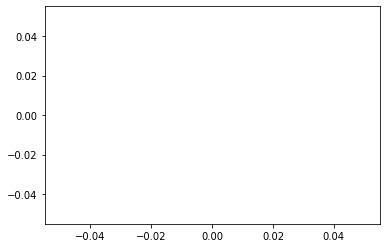

In [49]:
plt.plot(entropy_VN)

base
<class 'list'> <class 'qutip.qobj.Qobj'>
dim= 2
base
<class 'list'> <class 'qutip.qobj.Qobj'>
dim= 2
base
<class 'list'> <class 'qutip.qobj.Qobj'>
dim= 2


Text(0.5, 1.0, ' BW Dinámica cerrada no gaussiana wb1=3.0 wb2=6.928203230275509')

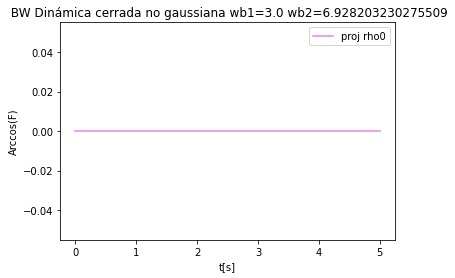

In [ ]:
result, title = projected_evolution(x=.1, gamma = 1*np.e**-2, omega_1=3., omega_2=np.sqrt(48), temp=1, gaussian=True, deltat=5., tmax=10., distance=bures)

plt.plot(result.times, result.projrho0_app, color="violet", label="proj rho0")
plt.xlabel("t[s]")
plt.ylabel("Arccos(F)")

plt.legend()
plt.title(title)

In [ ]:
a=4.2


In [ ]:
math.isnan(3.2)

False

In [ ]:
c_op_list = spin_dephasing(.1)
[type(o) for o in c_op_list]

[qutip.qobj.Qobj,
 qutip.qobj.Qobj,
 qutip.qobj.Qobj,
 qutip.qobj.Qobj,
 qutip.qobj.Qobj]

In [34]:
rho0 = qutip.tensor([.5*qutip.qeye(2) for k in range(3)])
id5 = .125*qutip.qeye(2**3)
print(rho0)
print(id5)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[0.125 0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.125 0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.125 0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.125 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.125 0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.125 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.125 0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.125]]
Quantum object: dims = [[8], [8]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[0.125 0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.125 0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.125 0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.125 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.125 0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.125 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.125 0.   ]
 [0.    0.    0.    0.    0.    0.    0.  